In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, timedelta
import numpy as np

In [2]:
juvenile_df = pd.read_csv('../Data/juvenile_clean.csv', index_col = 0, dtype={5: str})

In [3]:
juvenile_df['CheckoutDate'] = pd.to_datetime(juvenile_df['CheckoutDate'])

## General Data Description

In [4]:
juvenile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6443528 entries, 0 to 6443527
Data columns (total 23 columns):
 #   Column            Dtype         
---  ------            -----         
 0   UsageClass        object        
 1   MaterialType      object        
 2   Checkouts         int64         
 3   Title             object        
 4   ISBN              object        
 5   Creator           object        
 6   Subjects          object        
 7   Publisher         object        
 8   PublicationYear   object        
 9   CheckoutDate      datetime64[ns]
 10  TitleNotes        object        
 11  CreatorName       object        
 12  CopyrightList     object        
 13  CopyrightDate     float64       
 14  PCopyrightList    object        
 15  PCopyrightDate    float64       
 16  PrintingDate      float64       
 17  ApproxDate        float64       
 18  PubDate           float64       
 19  OtherDateList     object        
 20  OtherDate         float64       
 21  CreatedDate  

In [5]:
juvenile_df['UsageClass'].value_counts(dropna=False)

UsageClass
Physical    4528917
Digital     1914611
Name: count, dtype: int64

In [6]:
juvenile_df['MaterialCategory'].value_counts()

MaterialCategory
Book         4232868
E-book       1416036
Audiobook     708660
Video          83725
Other           1467
Music            772
Name: count, dtype: int64

In [7]:
juvenile_df['CheckoutDate'].describe()

count                          6443528
mean     2018-01-15 22:05:10.878637312
min                2005-04-01 00:00:00
25%                2014-05-01 00:00:00
50%                2018-08-01 00:00:00
75%                2022-08-01 00:00:00
max                2025-11-01 00:00:00
Name: CheckoutDate, dtype: object

In [8]:
books_df = juvenile_df.loc[juvenile_df.MaterialCategory.isin(['Book', 'E-book', 'Audiobook'])].reset_index()

In [9]:
books_df[['Title', 'CreatorName']].drop_duplicates().shape[0]

127254

In [10]:
books_df['CheckoutDate'].describe()

count                          6357564
mean     2018-02-06 14:50:34.848442112
min                2005-04-01 00:00:00
25%                2014-06-01 00:00:00
50%                2018-09-01 00:00:00
75%                2022-09-01 00:00:00
max                2025-11-01 00:00:00
Name: CheckoutDate, dtype: object

## Overall Most Popular Books

In [11]:
top10_overall = books_df.groupby(['CreatorName', 'Title'], as_index = False).agg(Checkouts = ('Checkouts', 'sum'), Created = ('CreatedDate', 'min')).sort_values('Checkouts', ascending = False).head(10).rename(columns = {'Checkouts': 'TotalCheckouts'})

In [12]:
top10_overall = pd.merge(top10_overall, books_df.groupby(['CreatorName', 'Title', 'UsageClass'], as_index = False)['Checkouts'].sum(), how = 'inner', on = ['CreatorName', 'Title']).pivot(index = ['CreatorName', 'Title', 'Created', 'TotalCheckouts'], columns = 'UsageClass', values = 'Checkouts').reset_index().sort_values('TotalCheckouts', ascending = False).reset_index(drop = True)

In [13]:
top10_overall

UsageClass,CreatorName,Title,Created,TotalCheckouts,Digital,Physical
0,J. K. Rowling,Harry Potter And The Sorcerer's Stone,1998.0,34694,19913.0,14781.0
1,J. K. Rowling,Harry Potter And The Chamber Of Secrets,1999.0,27910,16057.0,11853.0
2,J. K. Rowling,Harry Potter And The Prisoner Of Azkaban,1999.0,22054,11985.0,10069.0
3,J. K. Rowling,Harry Potter And The Half-Blood Prince,2005.0,20203,6369.0,13834.0
4,J. K. Rowling,Harry Potter And The Deathly Hallows,2007.0,17710,6129.0,11581.0
5,J. K. Rowling,Harry Potter And The Goblet Of Fire,2000.0,17060,7233.0,9827.0
6,J. K. Rowling,Harry Potter And The Order Of The Phoenix,2003.0,16606,6704.0,9902.0
7,R. J. Palacio,Wonder,2012.0,16007,7683.0,8324.0
8,Madeleine L'Engle,A Wrinkle In Time,1962.0,15963,6706.0,9257.0
9,Mo Willems,Are You Ready To Play Outside?,2008.0,12774,NaN,12774.0


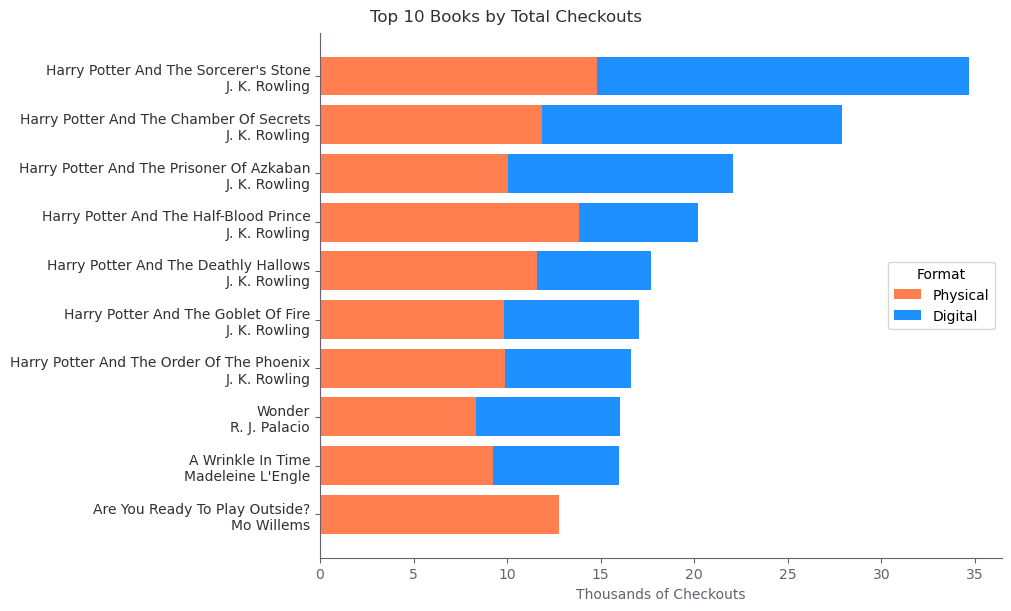

In [14]:
##resort data for graphing
df = top10_overall.sort_values('TotalCheckouts').reset_index(drop = True)

## Build the graph
fig, ax = plt.subplots(figsize = (10,6), layout = 'constrained')

y = np.arange(10)

ax.barh(y, df['Physical']/1000, color = 'coral', label = 'Physical')
ax.barh(y, df['Digital']/1000, left = df['Physical']/1000, color = 'dodgerblue', label = 'Digital')



## Graph title
plt.suptitle('Top 10 Books by Total Checkouts', color = '#342E37')

## Axis & legend customization
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('#6A5F6F')
ax.set_xlabel("Thousands of Checkouts", color = '#6A5F6F')
ax.set_yticks(y)
ax.tick_params(colors = '#6A5F6F')
ax.set_yticklabels(df.Title + '\n' + df.CreatorName, color = '#342E37')

ax.legend(title="Format")

plt.savefig('../Images/Fig1-Most_Popular_Books.png', transparent = True) 

## Different Trend Patterns

In [15]:
top10_OT = pd.merge(juvenile_df, top10_overall, how = 'inner', on = ['CreatorName', 'Title'])

In [16]:
trend_diff_df = top10_OT.groupby(['CreatorName', 'Title', 'CheckoutDate'], as_index = False)['Checkouts'].sum().groupby(['CreatorName', 'Title'], as_index = False).agg(Max = ('Checkouts', 'max'), Min = ('Checkouts', 'min'))

In [17]:
trend_diff_df['Diff'] = trend_diff_df['Max'] - trend_diff_df['Min']

In [18]:
trend_diff_df = trend_diff_df.sort_values('Diff').reset_index(drop = True)

In [19]:
trend_diff_df

,CreatorName,Title,Max,Min,Diff
0,Mo Willems,Are You Ready To Play Outside?,129,1,128
1,J. K. Rowling,Harry Potter And The Order Of The Phoenix,159,2,157
2,J. K. Rowling,Harry Potter And The Goblet Of Fire,188,5,183
3,J. K. Rowling,Harry Potter And The Prisoner Of Azkaban,263,10,253
4,J. K. Rowling,Harry Potter And The Chamber Of Secrets,302,10,292
5,J. K. Rowling,Harry Potter And The Half-Blood Prince,318,4,314
6,J. K. Rowling,Harry Potter And The Deathly Hallows,446,2,444
7,Madeleine L'Engle,A Wrinkle In Time,540,5,535
8,R. J. Palacio,Wonder,725,4,721
9,J. K. Rowling,Harry Potter And The Sorcerer's Stone,2637,17,2620


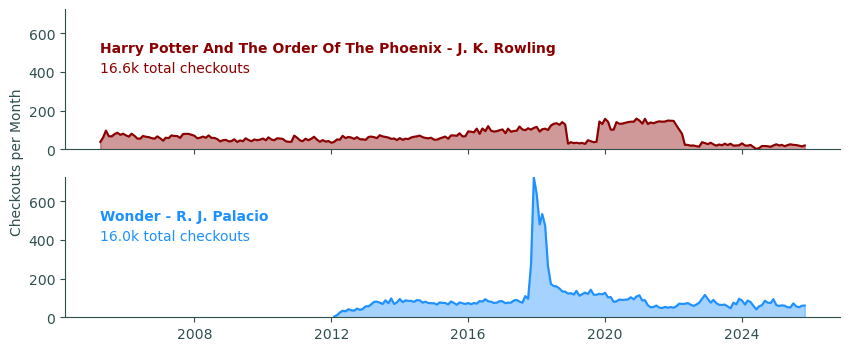

In [20]:
## narrow data to graph
trends_chart = trend_diff_df.iloc[[1,8]]

## Build the graph
fig, ax = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (10,4))

count = 0
colors = ['darkred', 'dodgerblue']

for i, r in trends_chart.iterrows():
    ## get facts for current title
    title = r['Title']
    author = r['CreatorName']
    filtered = top10_OT.loc[top10_OT['Title'] == title].groupby(['Title', 'CreatorName', 'CheckoutDate'], as_index = False)['Checkouts'].sum()
    total_checkouts = filtered.Checkouts.sum()

    ## graph checkouts over time
    ax[count].fill_between(filtered['CheckoutDate'], filtered['Checkouts'], color = colors[count], alpha = .4)
    ax[count].plot(filtered['CheckoutDate'], filtered['Checkouts'], color = colors[count])

    ## add chart labels
    ax[count].text(s = title + ' - ' + author, y = 500, x = top10_OT.CheckoutDate.min(), 
                   color = colors[count], fontweight = 'semibold')
    ax[count].text(s = str(round(total_checkouts/1000, 1)) + 'k total checkouts', y = 400, x = top10_OT.CheckoutDate.min(), 
                   color = colors[count])

    ## format chart appearance
    ax[count].spines[['top', 'right']].set_visible(False)
    ax[count].spines[['left', 'bottom']].set_color('darkslategray')
    ax[count].set_ylim([0, trends_chart['Max'].max()])
    ax[count].tick_params(axis = 'y', colors = 'darkslategray', labelrotation = 0)
    ax[count].tick_params(axis = 'x', colors = 'darkslategray')

    ## increment counter
    count += 1


## y-axis label
fig.text(0.07, 0.5, 'Checkouts per Month', va = 'center', rotation = 'vertical', color = 'darkslategray')


plt.savefig('../Images/Fig2-Different_Trends', transparent = True) 

In [21]:
for i, r in trends_chart.iterrows():
    filtered = top10_OT.loc[top10_OT['Title'] == r.Title].groupby(['Title', 'CreatorName', 'CheckoutDate'], as_index = False)['Checkouts'].sum()
    avg_checkouts = filtered.Checkouts.median()
    print(r.Title, ': ', str(avg_checkouts))

Harry Potter And The Order Of The Phoenix :  59.0
Wonder :  76.0


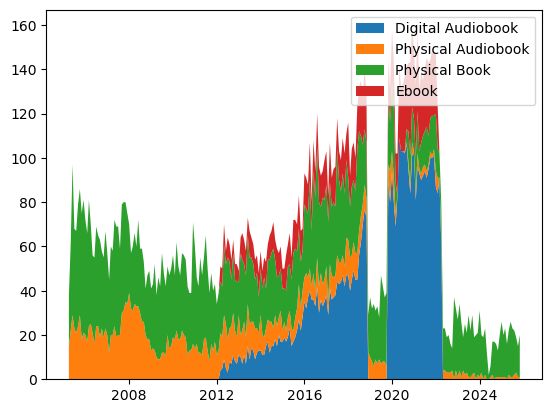

In [22]:
title = 'Harry Potter And The Order Of The Phoenix'
author = 'J. K. Rowling'

filtered = books_df.loc[(books_df['Title'] == title) & (books_df['CreatorName'] == author)]
filtered = filtered.groupby(['CreatorName', 'Title', 'MaterialCategory', 'UsageClass', 'CheckoutDate'], as_index = False).agg(Checkouts = ('Checkouts', 'sum')).pivot(index = ['CreatorName', 'Title', 'CheckoutDate'], columns = ['MaterialCategory', 'UsageClass'], values = 'Checkouts').reset_index().fillna(0)
filtered.columns = [f'{i} - {j}' if (i != '') & (j != '') else i + j for i, j in [x for x in filtered.columns]]
plt.stackplot(filtered['CheckoutDate'], filtered['Audiobook - Digital'], filtered['Audiobook - Physical'], filtered['Book - Physical'], filtered['E-book - Digital'], labels = ['Digital Audiobook', 'Physical Audiobook', 'Physical Book', 'Ebook'])
plt.legend()

## Spikes / Fads

In [23]:
def q25(x):
    return x.quantile(.25)

In [24]:
def q75(x):
    return x.quantile(.75)

#### Where would Wonder be w/o the movie?

In [25]:
wonder = books_df.loc[(books_df['Title'] == 'Wonder') & (books_df['CreatorName'] == 'R. J. Palacio')]

In [26]:
wonder = wonder.groupby(['CreatorName', 'Title', 'CheckoutDate'], as_index = False)['Checkouts'].sum()

In [27]:
wonder_summary = wonder.groupby(['Title', 'CreatorName'], as_index = False)['Checkouts'].agg(['count', 'mean', 'min', q25, 'median', q75, 'max'])

In [28]:
wonder_summary['IQR'] = wonder_summary.q75 - wonder_summary.q25

In [29]:
wonder_summary['Outlier_bound'] = wonder_summary.q75 + (1.5 * wonder_summary.IQR)

In [30]:
wonder_outlier = wonder_summary.loc[0, 'Outlier_bound']

In [31]:
wonder.CheckoutDate.nunique()

166

In [32]:
wonder.loc[wonder['Checkouts'] < wonder_outlier, 'Checkouts'].agg(['mean', 'median', 'sum'])

mean         76.805195
median       76.000000
sum       11828.000000
Name: Checkouts, dtype: float64

In [33]:
wonder.CheckoutDate.nunique() * wonder.loc[wonder['Checkouts'] < wonder_outlier, 'Checkouts'].mean()

12749.662337662337

#### Which titles had the biggest spikes in popularity?

In [34]:
books_spread = books_df.groupby(['Title', 'CreatorName', 'CheckoutDate'], as_index = False)['Checkouts'].sum()

In [35]:
books_spread = books_spread.groupby(['Title', 'CreatorName'], as_index = False)['Checkouts'].agg(['count', 'mean', 'min', q25, 'median', q75, 'max'])

In [36]:
books_spread['range'] = books_spread['max'] - books_spread['min']

In [37]:
books_spread['IQR'] = books_spread['q75'] - books_spread['q25']

In [38]:
books_spread = books_spread.rename(columns = {'count': 'months'})

In [39]:
books_spread['spike'] = books_spread['max'] - books_spread['median']

In [40]:
top_spread = books_spread.sort_values('spike', ascending = False).head(10)

In [41]:
top_spread

,Title,CreatorName,months,mean,min,q25,median,q75,max,range,IQR,spike
36260,Harry Potter And The Sorcerer's Stone,J. K. Rowling,248,139.895161,17,56.75,111.0,164.00,2637,2620,107.25,2526.0
43113,Invisible: A Graphic Novel,Christina Diaz Gonzalez,40,76.050000,1,9.75,22.5,33.00,850,849,23.25,827.5
109199,Turtles All The Way Down,John Green,93,46.290323,1,5.00,9.0,24.00,777,776,19.00,768.0
99617,The Red Pencil,Andrea Davis Pinkney,133,23.857143,1,3.00,6.0,11.00,752,751,8.00,746.0
116231,Wonder,R. J. Palacio,166,96.427711,4,64.25,76.0,93.75,725,721,29.50,649.0
92922,The Hate U Give,Angie Thomas,101,80.623762,1,9.00,17.0,61.00,595,594,52.00,578.0
3594,A Wrinkle In Time,Madeleine L'Engle,243,65.691358,5,24.50,33.0,68.00,540,535,43.50,507.0
55492,Mexikid: (Newbery Honor Award Winner),Pedro Martín,8,67.125000,4,6.50,8.5,10.50,482,478,4.00,473.5
40487,I Can Make This Promise,Christine Day,74,34.445946,4,11.00,16.0,25.75,480,476,14.75,464.0
38757,Hot Mess,Jeff Kinney,14,353.214286,202,244.50,326.5,368.00,780,578,123.50,453.5


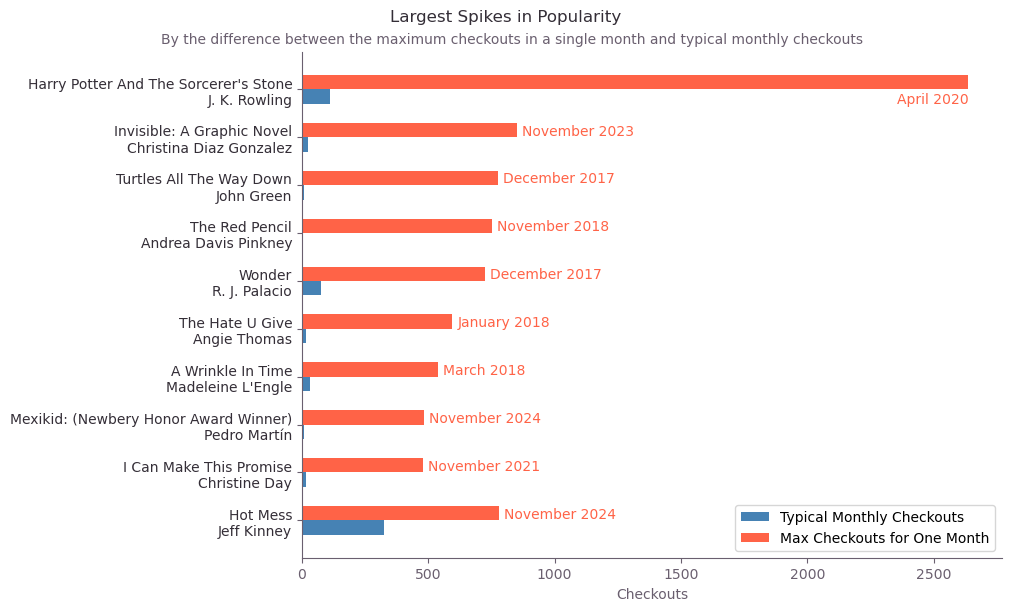

In [42]:
##resort data for graphing
df = top_spread.sort_values('spike').reset_index(drop = True)

## Build the graph
fig, ax = plt.subplots(figsize = (10,6), layout = 'constrained')

bar_width = .3
y1 = np.arange(10) - (bar_width/2)
y2 = y1 + bar_width

ax.barh(y1, df['median'], height = bar_width, color = 'steelblue', label = 'Typical Monthly Checkouts')
ax.barh(y2, df['max'], height = bar_width, color = 'tomato', label = 'Max Checkouts for One Month')

## Add month callouts for maximum values
for i, r in df.iterrows():
    filtered = books_df.loc[(books_df['Title'] == r.Title) & (books_df['CreatorName'] == r.CreatorName)]
    filtered = filtered.groupby('CheckoutDate', as_index = False)['Checkouts'].sum()
    max_date = filtered.loc[filtered['Checkouts'] == r['max'], 'CheckoutDate'].dt.strftime('%B %Y').values[0]
    if i == 9:
        plt.text(s = max_date, y = i - bar_width, x = r['max'], ha = 'right', color = 'tomato')
    else:
        plt.text(s = max_date, y = i + (bar_width/2) - .1, x = r['max'] + 20, color = 'tomato')
    

## Graph title
plt.suptitle('Largest Spikes in Popularity', color = '#342E37')
plt.title('By the difference between the maximum checkouts in a single month and typical monthly checkouts', color = '#6A5F6F', size = 'medium', x = .3)

## Axis & legend customization
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('#6A5F6F')
ax.set_xlabel("Checkouts", color = '#6A5F6F')
ax.set_yticks(np.arange(10))
ax.tick_params(colors = '#6A5F6F')
ax.set_yticklabels(df.Title + '\n' + df.CreatorName, color = '#342E37')

ax.legend()


plt.savefig('../Images/Fig3-Largest_Spikes.png', transparent = True) 

Text(0.07, 0.5, 'Checkouts per Month')

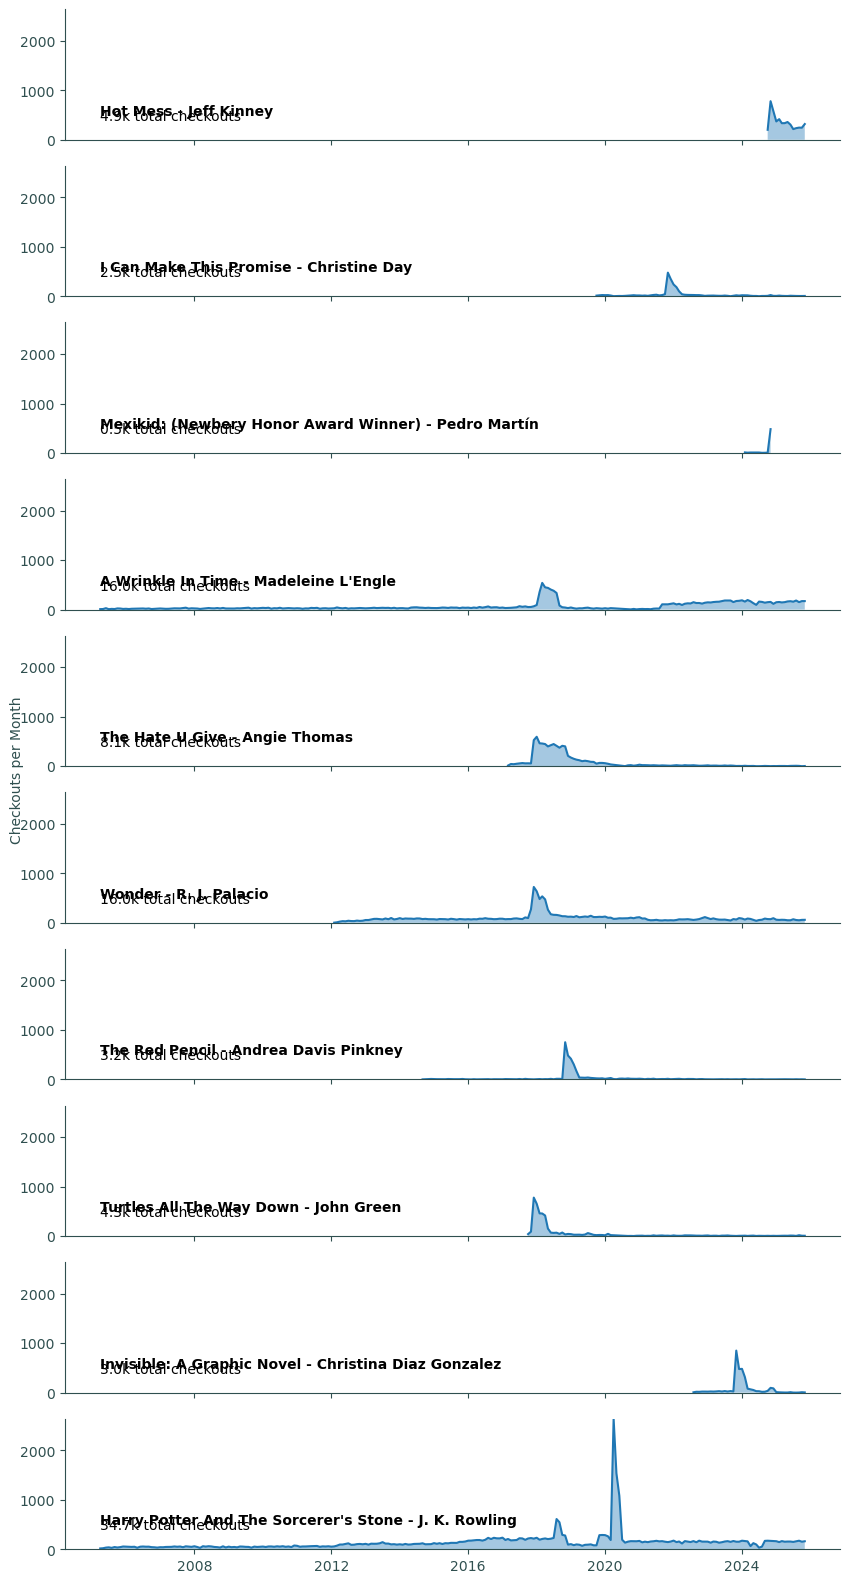

In [43]:

## Build the graph
fig, ax = plt.subplots(nrows = len(df), ncols = 1, sharex = True, figsize = (10,20))

count = 0

for i, r in df.iterrows():
    ## get facts for current title
    title = r['Title']
    author = r['CreatorName']
    filtered = books_df.loc[(books_df['Title'] == title) & (books_df['CreatorName'] == author)].groupby(['Title', 'CreatorName', 'CheckoutDate'], as_index = False)['Checkouts'].sum()
    total_checkouts = filtered.Checkouts.sum()

    ## graph checkouts over time
    ax[count].fill_between(filtered['CheckoutDate'], filtered['Checkouts'], alpha = .4)
    ax[count].plot(filtered['CheckoutDate'], filtered['Checkouts'])

    ## add chart labels
    ax[count].text(s = title + ' - ' + author, y = 500, x = top10_OT.CheckoutDate.min(), 
                   fontweight = 'semibold')
    ax[count].text(s = str(round(total_checkouts/1000, 1)) + 'k total checkouts', y = 400, x = top10_OT.CheckoutDate.min(), 
                   )

    ## format chart appearance
    ax[count].spines[['top', 'right']].set_visible(False)
    ax[count].spines[['left', 'bottom']].set_color('darkslategray')
    ax[count].set_ylim([0, df['max'].max()])
    ax[count].tick_params(axis = 'y', colors = 'darkslategray', labelrotation = 0)
    ax[count].tick_params(axis = 'x', colors = 'darkslategray')

    ## increment counter
    count += 1


## y-axis label
fig.text(0.07, 0.5, 'Checkouts per Month', va = 'center', rotation = 'vertical', color = 'darkslategray')

## Consistent Popularity

In [44]:
med_checkouts = books_df.groupby(['CreatorName', 'Title', 'CheckoutDate'], as_index = False).agg(Checkouts = ('Checkouts', 'sum'), Created = ('CreatedDate', 'min'))

In [45]:
med_checkouts = med_checkouts.groupby(['CreatorName', 'Title', 'Created'], as_index = False).agg(Months = ('CheckoutDate', 'nunique'), MedCheckouts = ('Checkouts', 'median'))

In [46]:
top_med_checkouts = med_checkouts.loc[med_checkouts['Months'] >= 12].sort_values('MedCheckouts')

In [47]:
top10_median = top_med_checkouts.tail(10)

In [48]:
top10_median['shortTitle'] = np.where(top10_median.Title.str.len() > 40, top10_median.Title.str[:32] + '...', top10_median.Title)

C:\Users\5pira\AppData\Local\Temp\ipykernel_20632\1186869531.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10_median['shortTitle'] = np.where(top10_median.Title.str.len() > 40, top10_median.Title.str[:32] + '...', top10_median.Title)


In [49]:
top10_median

,CreatorName,Title,Created,Months,MedCheckouts,shortTitle
58899,Jeff Kinney,Wrecking Ball,2019.0,73,85.0,Wrecking Ball
28785,Dav Pilkey,"Grime And Punishment: Dog Man Series, Book 9",2020.0,30,94.0,Grime And Punishment: Dog Man Se...
109921,Rick Riordan,The Chalice Of The Gods,2023.0,27,101.0,The Chalice Of The Gods
53000,J. K. Rowling,Harry Potter And The Sorcerer's Stone,1998.0,243,109.0,Harry Potter And The Sorcerer's Stone
58690,Jeff Kinney,Big Shot,2021.0,49,117.0,Big Shot
58847,Jeff Kinney,The Deep End,2020.0,62,119.0,The Deep End
58751,Jeff Kinney,Diper Överlöde,2022.0,37,121.0,Diper Överlöde
52988,J. K. Rowling,Harry Potter And The Cursed Child: Parts One A...,2016.0,26,180.0,Harry Potter And The Cursed Chil...
58823,Jeff Kinney,No Brainer,2023.0,26,235.5,No Brainer
58807,Jeff Kinney,Hot Mess,2024.0,14,326.5,Hot Mess


In [50]:
top10_median.Months.median() / 12

2.7916666666666665

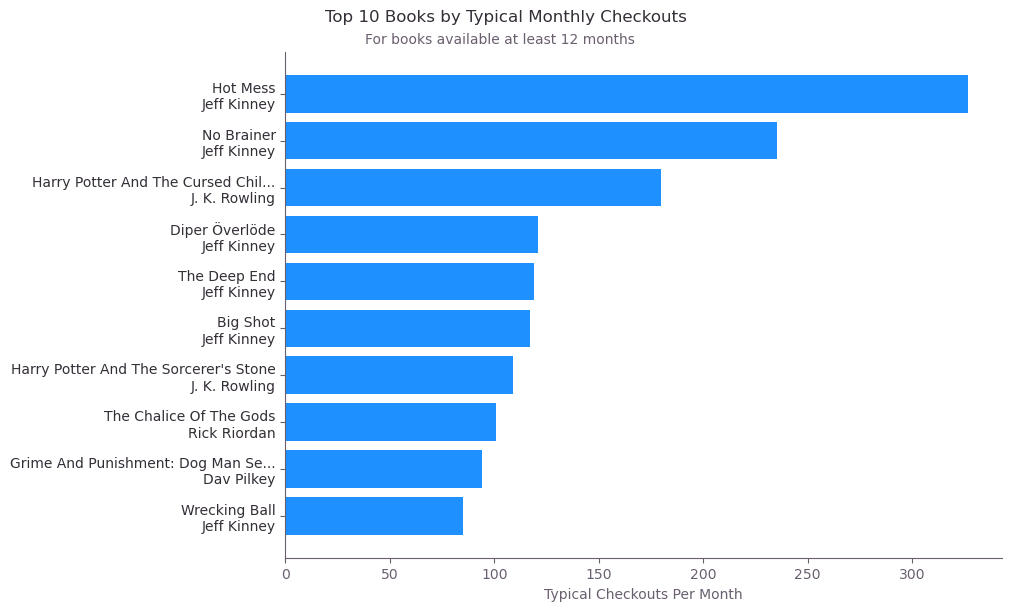

In [51]:
## Build the graph
fig, ax = plt.subplots(figsize = (10,6), layout = 'constrained')

ax.barh(np.arange(10), top10_median['MedCheckouts'], color = 'dodgerblue')

## Graph title
plt.suptitle('Top 10 Books by Typical Monthly Checkouts', color = '#342E37')
plt.title('For books available at least 12 months', color = '#6A5F6F', size = 'medium', x = .3)

## Axis & legend customization
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('#6A5F6F')
ax.set_xlabel("Typical Checkouts Per Month", color = '#6A5F6F')
ax.set_yticks(np.arange(10))
ax.tick_params(colors = '#6A5F6F')
ax.set_yticklabels(top10_median.shortTitle + '\n' + top10_median.CreatorName, color = '#342E37')


plt.savefig('../Images/Fig4-Top_Med_Monthly_Checkouts.png', transparent = True) 

Text(0.07, 0.5, 'Checkouts per Month')

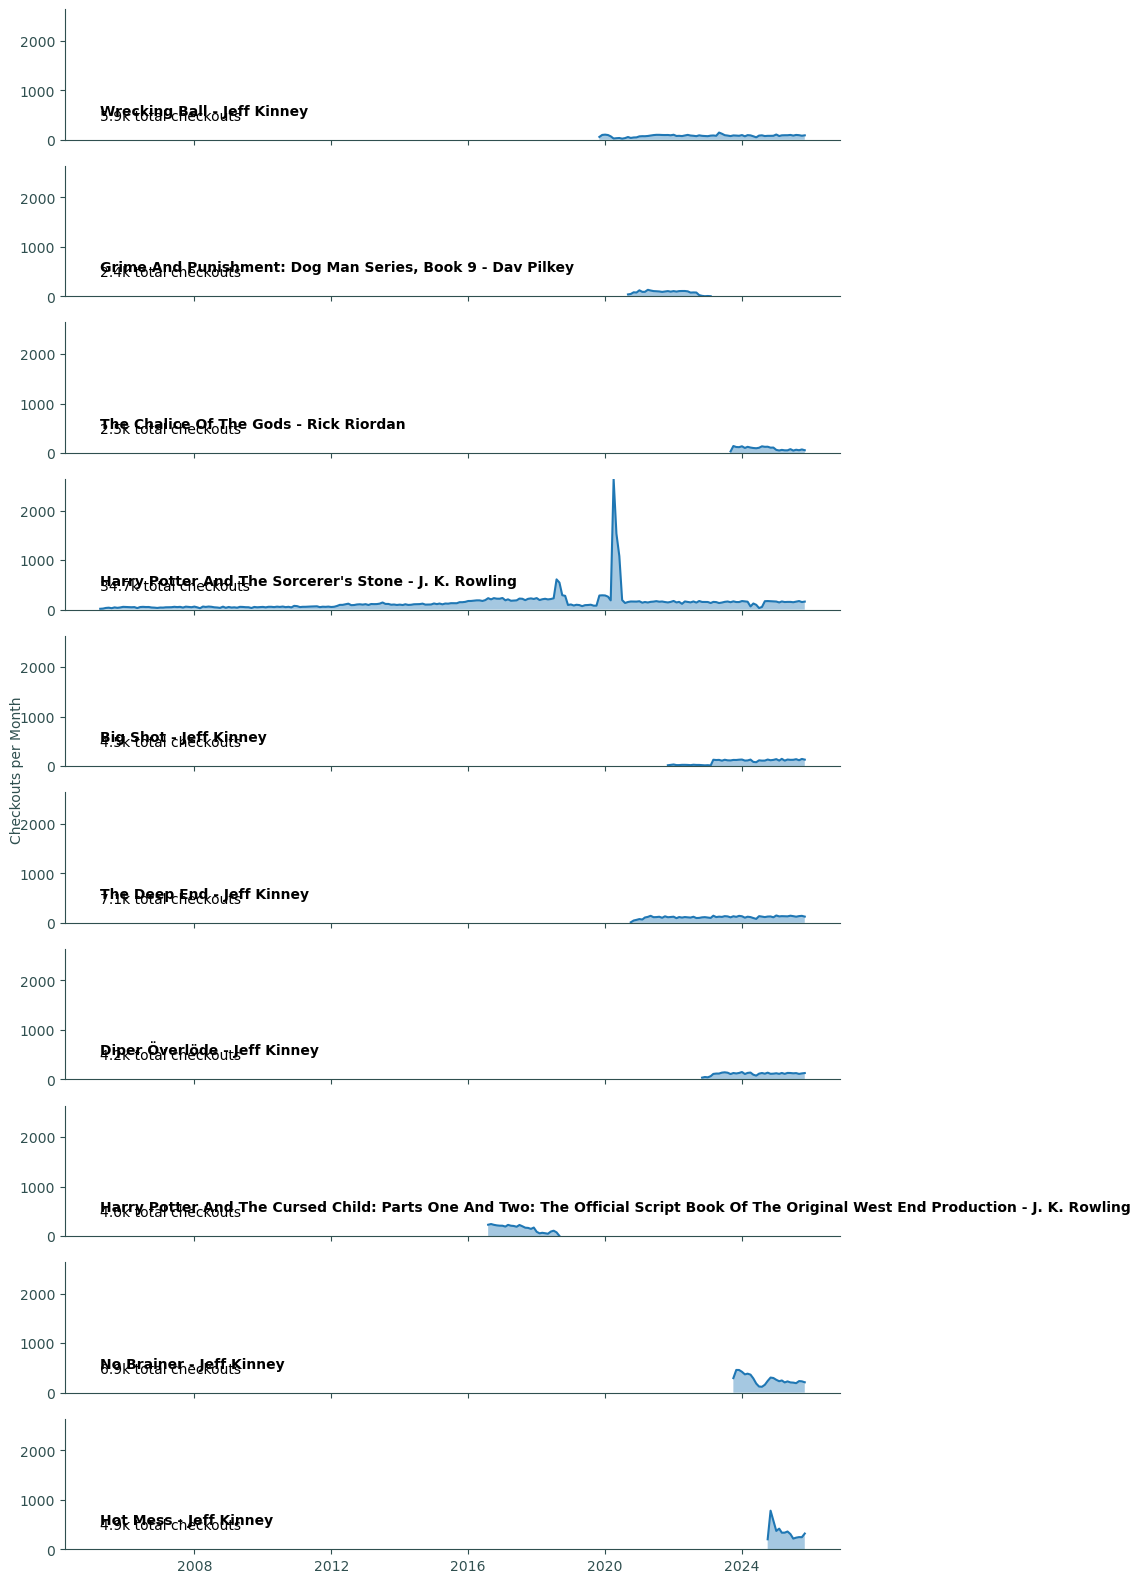

In [52]:

## Build the graph
fig, ax = plt.subplots(nrows = len(df), ncols = 1, sharex = True, figsize = (10,20))

count = 0

for i, r in top10_median.iterrows():
    ## get facts for current title
    title = r['Title']
    author = r['CreatorName']
    filtered = books_df.loc[(books_df['Title'] == title) & (books_df['CreatorName'] == author)].groupby(['Title', 'CreatorName', 'CheckoutDate'], as_index = False)['Checkouts'].sum()
    total_checkouts = filtered.Checkouts.sum()

    ## graph checkouts over time
    ax[count].fill_between(filtered['CheckoutDate'], filtered['Checkouts'], alpha = .4)
    ax[count].plot(filtered['CheckoutDate'], filtered['Checkouts'])

    ## add chart labels
    ax[count].text(s = title + ' - ' + author, y = 500, x = top10_OT.CheckoutDate.min(), 
                   fontweight = 'semibold')
    ax[count].text(s = str(round(total_checkouts/1000, 1)) + 'k total checkouts', y = 400, x = top10_OT.CheckoutDate.min(), 
                   )

    ## format chart appearance
    ax[count].spines[['top', 'right']].set_visible(False)
    ax[count].spines[['left', 'bottom']].set_color('darkslategray')
    ax[count].set_ylim([0, df['max'].max()])
    ax[count].tick_params(axis = 'y', colors = 'darkslategray', labelrotation = 0)
    ax[count].tick_params(axis = 'x', colors = 'darkslategray')

    ## increment counter
    count += 1


## y-axis label
fig.text(0.07, 0.5, 'Checkouts per Month', va = 'center', rotation = 'vertical', color = 'darkslategray')

## Changes over time

In [53]:
books_df['CheckoutYear'] = books_df.CheckoutDate.dt.year

In [54]:
benchmark2006 = books_df.loc[books_df['CheckoutYear'] == 2006].groupby(['CheckoutYear', 'CreatorName', 'Title'], as_index = False)['Checkouts'].sum().sort_values('Checkouts', ascending = False).head(100)

In [55]:
benchmark2011 = books_df.loc[books_df['CheckoutYear'] == 2011].groupby(['CheckoutYear', 'CreatorName', 'Title'], as_index = False)['Checkouts'].sum().sort_values('Checkouts', ascending = False).head(100)

In [56]:
benchmark2016 = books_df.loc[books_df['CheckoutYear'] == 2016].groupby(['CheckoutYear', 'CreatorName', 'Title'], as_index = False)['Checkouts'].sum().sort_values('Checkouts', ascending = False).head(100)

In [57]:
benchmark2021 = books_df.loc[books_df['CheckoutYear'] == 2021].groupby(['CheckoutYear', 'CreatorName', 'Title'], as_index = False)['Checkouts'].sum().sort_values('Checkouts', ascending = False).head(100)

In [58]:
over_time_df = []

for year in books_df.CheckoutYear.unique():
    ## check number of months with data for that year, and only compare complete years
    months = books_df.loc[books_df['CheckoutYear'] == year, 'CheckoutDate'].unique()
    if len(months) == 12:
        df = books_df.loc[books_df['CheckoutYear'] == year].groupby(['CheckoutYear', 'CreatorName', 'Title'], as_index = False)['Checkouts'].sum().sort_values('Checkouts', ascending = False).head(100)
        
        ## compare top 100 books to benchmark years
        match2006 = pd.merge(df, benchmark2006, how = 'inner', on = ['CreatorName', 'Title']).shape[0]
        ## but only compare to benchmark years in the past
        if year >= 2011:
            match2011 = pd.merge(df, benchmark2011, how = 'inner', on = ['CreatorName', 'Title']).shape[0]
        if year >= 2016:
            match2016 = pd.merge(df, benchmark2016, how = 'inner', on = ['CreatorName', 'Title']).shape[0]
        if year >= 2021:
            match2021 = pd.merge(df, benchmark2021, how = 'inner', on = ['CreatorName', 'Title']).shape[0]

        ## append results for final data frame
        over_time_df.append({'Year': year, '2006': match2006, '2011': match2011, '2016': match2016, '2021': match2021})

    ## clear variables
    match2006 = np.nan
    match2011 = np.nan
    match2016 = np.nan
    match2021 = np.nan
    

over_time_df = pd.DataFrame(over_time_df).sort_values('Year').reset_index(drop = True)
over_time_df['Year'] = pd.to_datetime(over_time_df['Year'].astype(str) + '-01-01')
over_time_df

,Year,2006,2011,2016,2021
0,2006-01-01,100,NaN,NaN,NaN
1,2007-01-01,83,NaN,NaN,NaN
2,2008-01-01,55,NaN,NaN,NaN
3,2009-01-01,39,NaN,NaN,NaN
4,2010-01-01,29,NaN,NaN,NaN
5,2011-01-01,23,100.0,NaN,NaN
6,2012-01-01,15,58.0,NaN,NaN
7,2013-01-01,14,46.0,NaN,NaN
8,2014-01-01,10,37.0,NaN,NaN
9,2015-01-01,13,30.0,NaN,NaN


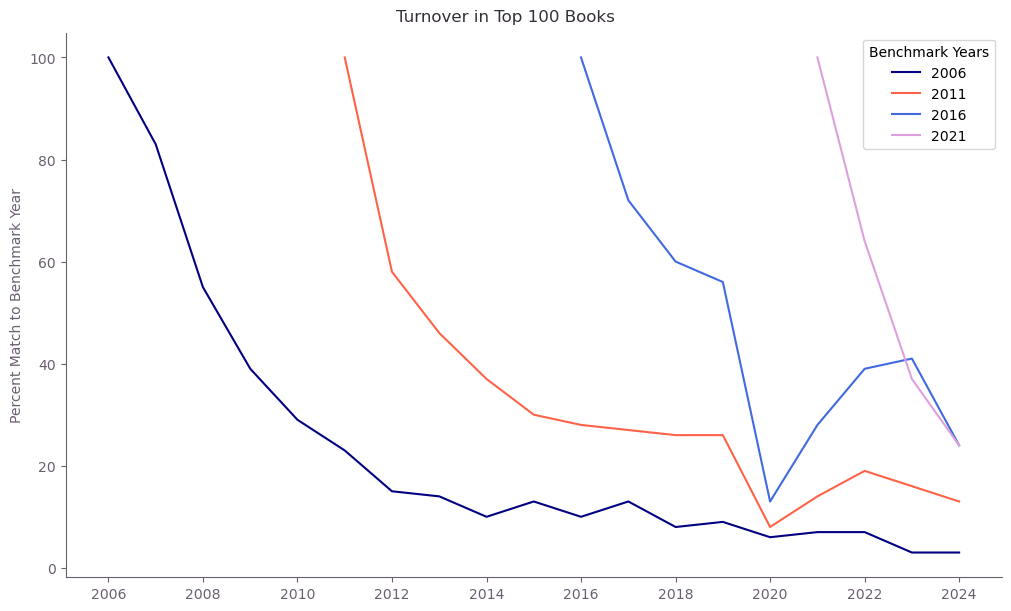

In [59]:
## Build the graph
fig, ax = plt.subplots(figsize = (10,6), layout = 'constrained')

ax.plot(over_time_df['Year'], over_time_df['2006'], color = 'navy', label = '2006')
ax.plot(over_time_df['Year'], over_time_df['2011'], color = 'tomato', label = '2011')
ax.plot(over_time_df['Year'], over_time_df['2016'], color = 'royalblue', label = '2016')
ax.plot(over_time_df['Year'], over_time_df['2021'], color = 'plum', label = '2021')


## Graph title
plt.suptitle('Turnover in Top 100 Books', color = '#342E37')

## Axis & legend customization
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('#6A5F6F')
ax.set_ylabel("Percent Match to Benchmark Year", color = '#6A5F6F')
ax.tick_params(colors = '#6A5F6F')

ax.legend(title="Benchmark Years")


plt.savefig('../Images/Fig5-Top_Books_Over_Time', transparent = True) 

In [60]:
prev_year_comp = []
prev_year = pd.DataFrame()

for year in books_df.CheckoutYear.sort_values().unique():
    ## check number of months with data for that year, and only compare complete years
    months = books_df.loc[books_df['CheckoutYear'] == year, 'CheckoutDate'].unique()
    if len(months) == 12:
        curr_df = books_df.loc[books_df['CheckoutYear'] == year].groupby(['CheckoutYear', 'CreatorName', 'Title'], as_index = False)['Checkouts'].sum().sort_values('Checkouts', ascending = False).head(100)

        if len(prev_year) > 0:
            match_pct = pd.merge(curr_df, prev_year, how = 'inner', on = ['CreatorName', 'Title']).shape[0]
            prev_year_comp.append({'Year': year, 'Match_Pct': match_pct})   
            
        prev_year = curr_df
        match_pct = np.nan


prev_year_comp = pd.DataFrame(prev_year_comp).sort_values('Year').reset_index(drop = True)
prev_year_comp['Year'] = pd.to_datetime(prev_year_comp['Year'].astype(str) + '-01-01')
prev_year_comp

,Year,Match_Pct
0,2007-01-01,83
1,2008-01-01,61
2,2009-01-01,80
3,2010-01-01,75
4,2011-01-01,78
5,2012-01-01,58
6,2013-01-01,75
7,2014-01-01,77
8,2015-01-01,73
9,2016-01-01,72


In [61]:
prev_year_comp.Match_Pct.mean()

67.33333333333333

## Which books stayed in the top 100?

for each book, count how many years it was (a) available, and (b) in the top 100 for that year

In [92]:
book_stats = books_df.groupby(['CreatorName', 'Title', 'CheckoutYear'], as_index = False).agg(Created = ('CreatedDate', 'min'), Checkouts = ('Checkouts', 'sum'))

In [93]:
book_stats['Rank'] = book_stats.groupby('CheckoutYear')['Checkouts'].rank(ascending = False)

In [94]:
book_stats

,CreatorName,Title,CheckoutYear,Created,Checkouts,Rank
0,'Nathan Burgoine,Exit Plans For Teenage Freaks,2019,2018.0,6,33945.5
1,'Nathan Burgoine,Exit Plans For Teenage Freaks,2020,2018.0,2,42841.5
2,'Nathan Burgoine,Exit Plans For Teenage Freaks,2022,2018.0,1,58519.5
3,'Nathan Burgoine,Stuck With You,2023,2023.0,5,41031.0
4,'Nathan Burgoine,Stuck With You,2024,2023.0,3,47477.5
...,...,...,...,...,...,...
816138,［美］劳拉·英格斯·怀德,草原小镇,2020,2018.0,1,48807.0
816139,［美］劳拉·英格斯·怀德,草原小镇,2021,2018.0,1,56005.0
816140,ａｃｃｏｔｏｔｏふくだとしお＋あきこ,ポポくんのかきごおり,2024,2016.0,4,43227.0
816141,ａｃｃｏｔｏｔｏふくだとしお＋あきこ,ポポくんのかきごおり,2025,2016.0,7,34469.0


In [95]:
book_stats['top100'] = np.where(book_stats['Rank'] <= 100, True, False)

In [99]:
top100s = book_stats.groupby(['CreatorName', 'Title'], as_index = False).agg(Created = ('Created', 'min'), Years = ('CheckoutYear', 'nunique'), top100 = ('top100', 'sum'))

In [100]:
top100s['top100_pct'] = top100s['top100'] * 100 / top100s['Years']

In [101]:
top100s.loc[top100s['top100'] > 1].sort_values('top100_pct', ascending = False).head(30)

,CreatorName,Title,Created,Years,top100,top100_pct
25474,Dav Pilkey,Dog Man. Twenty Thousand Fleas Under The Sea,2023.0,3,3,100.000000
51524,Jeff Kinney,Diary Of A Wimpy Kid,2008.0,3,3,100.000000
8512,Arley Nopra,Claudia And The Bad Joke,2023.0,2,2,100.000000
25566,Dav Pilkey,On Purpose,2022.0,3,3,100.000000
9544,B. B. Alston,Amari And The Night Brothers: Supernatural Inv...,2021.0,2,2,100.000000
51579,Jeff Kinney,Hot Mess,2024.0,2,2,100.000000
51589,Jeff Kinney,No Brainer,2023.0,3,3,100.000000
46526,J. K. Rowling,Harry Potter And The Sorcerer's Stone,1998.0,21,21,100.000000
46525,J. K. Rowling,Harry Potter And The Prisoner Of Azkaban,1999.0,21,21,100.000000
46519,J. K. Rowling,Harry Potter And The Chamber Of Secrets,1999.0,21,21,100.000000


## Other questions to explore:
* Which *authors* are the most popular overall?  Most consistently popular?  Normalized for number of titles?
* How do results change when normalized for when (and how many) copies were available in SPL's catalog?
* How does releasing a new book impact an author's popularity in the next 12 months? 60 months?
* Are books that win awards more popular than books that didn't?